**Name:** Byaravalli Arun Suhag

**EID:** 53265857

# CS4487 - Tutorial 3
## Gender Classification from Face Images

In this tutorial you will train a classifier to predict whether a face image is male or female.

First we need to initialize Python.  Run the below cell.

In [1]:
%matplotlib inline
import IPython.core.display         
# setup output image format (Chrome works best)
IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
import glob
import os
import IPython.utils.warn as warn
random.seed(100)

C:\Anaconda2\lib\site-packages\sklearn\lda.py:4: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", DeprecationWarning)
C:\Anaconda2\lib\site-packages\sklearn\qda.py:4: DeprecationWarning: qda.QDA has been moved to discriminant_analysis.QuadraticDiscriminantAnalysis in 0.17 and will be removed in 0.19.
  "in 0.17 and will be removed in 0.19.", DeprecationWarning)


## 1. Loading Data and Pre-processing
We first need to load the images.  Download `photos-bw.zip`, and unzip it in the same directory as this ipynb file.  Then run the following cell to load the images.

In [2]:
filelist = glob.glob('photos-bw/*.png')
if len(filelist) == 0:
    warn.error("Could not find images in photos-bw directory!  " + 
               "Make sure you put it here: " + os.getcwd() )
else:
    imgdata = []
    genders = []
    for f in filelist:
        img = matplotlib.image.imread(f)
        imgdata.append(img)
        genders.append( int(f[len("photos-bw/")] == 'm') )  # 0 is female, 1 is male
    imgsize = img.shape

Each image is a 45x40 array of pixel values.  Run the below code to show an example:

(45L, 40L)


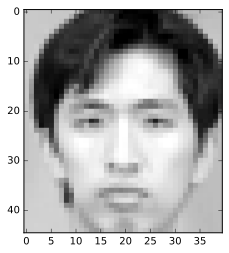

In [3]:
print img.shape
plt.imshow(img, cmap='gray', interpolation='nearest')
plt.show()

Run the below code to show all the images!

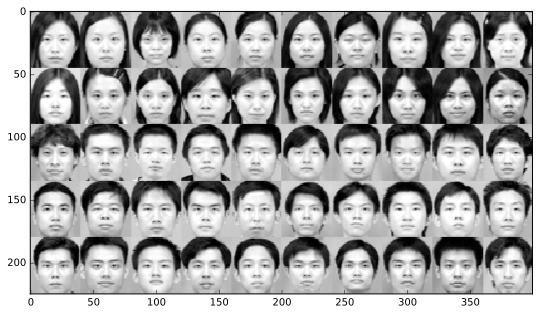

In [4]:
# function to make an image montage
def image_montage(X, imsize=None, maxw=10):
    """X can be a list of images, or a matrix of vectorized images.
      Specify imsize when X is a matrix."""
    tmp = []
    numimgs = len(X)
    
    # create a list of images (reshape if necessary)
    for i in range(0,numimgs):
        if imsize != None:
            tmp.append(X[i].reshape(imsize))
        else:
            tmp.append(X[i])
    
    # add blanks
    if (numimgs > maxw) and (mod(numimgs, maxw) > 0):
        leftover = maxw - mod(numimgs, maxw)
        meanimg = 0.5*(X[0].max()+X[0].min())
        for i in range(0,leftover):
            tmp.append(ones(tmp[0].shape)*meanimg)
    
    # make the montage
    tmp2 = []
    for i in range(0,len(tmp),maxw):
        tmp2.append( hstack(tmp[i:i+maxw]) )
    montimg = vstack(tmp2) 
    return montimg

plt.figure(figsize=(9,9))
plt.imshow(image_montage(imgdata), cmap='gray', interpolation='nearest')
plt.show()

Each image is a 2d array, but the classifier algorithms work on 1d vectors. Run the following code to convert all the images into 1d vectors by flattening.  The result should be a matrix where each row is a flattened image.

In [5]:
X = empty((50, prod(imgdata[0].shape))) # create empty array
for i,img in enumerate(imgdata):
    X[i,:] = ravel(img)           # for each image, turn it into a vector
Y = asarray(genders)  # convert list to numpy array
print X.shape
print Y.shape

(50L, 1800L)
(50L,)


Next we will shift the pixel values so that gray is 0.0, black is -0.5 and white is 0.5.

In [6]:
print "Before: min=%f, max=%f" % (X.min(), X.max())
X -= 0.5
print "After:  min=%f, max=%f" % (X.min(), X.max())

Before: min=0.000000, max=1.000000
After:  min=-0.500000, max=0.500000


Finally, split the dataset into a training set and testing set. We select 80% for training and 20% for testing.

In [7]:
# randomly split data into 80% train and 20% test set
trainX, testX, trainY, testY = \
  cross_validation.train_test_split(X, Y, 
  train_size=0.80, test_size=0.20, random_state=4487)

print trainX.shape
print testX.shape

(40L, 1800L)
(10L, 1800L)


# 2. Logistic Regression
Train a logistic regression classifier.  Use cross-validation to select the best C parameter.

In [8]:
### INSERT YOUR CODE HERE
logreg = linear_model.LogisticRegressionCV(Cs=logspace(-4,4,20), cv=5)
logreg.fit(trainX, trainY)

print "w=", logreg.coef_
print "b=", logreg.intercept_

w= [[ 0.00035113  0.00040657  0.00049916 ...,  0.01334931  0.01042594
   0.01006051]]
b= [-0.07932328]


Use the learned model to predict the genders for the training and testing data. What is the accuracy on the training set? What is the accuracy on the testing set?

test accuracy= 0.8
C =  [ 0.01274275]


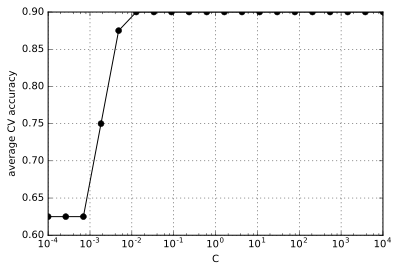

In [9]:
### INSERT YOUR CODE HERE


# predict from the model
predYtest = logreg.predict(testX)

# calculate accuracy
acc = metrics.accuracy_score(testY, predYtest)
print "test accuracy=", acc

print "C = ", logreg.C_

# calculate the average score for each C
avgscores = mean(logreg.scores_[1],0)  # 1 is the class label
plt.figure()
plt.semilogx(logreg.Cs_, avgscores, 'ko-')
plt.xlabel('C'); plt.ylabel('average CV accuracy')
plt.grid(True);


### Analyzing the classifier
Run the below code to show the hyperplane parameter $\mathbf{w}$ as an image.  

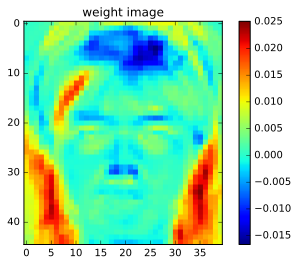

In [10]:
# logreg is the learned logistic regression model
wimg = logreg.coef_.reshape(imgsize)      # get the w and reshape into an image
plt.imshow(wimg, interpolation='nearest')
plt.colorbar()
plt.title("weight image")
plt.show()

Recall that the classifier prediction is based on the sign of the function $f(\mathbf{x}) = \mathbf{w}^T\mathbf{x}+b = \sum_{i=1}^P w_ix_i + b$.  Here each $x_i$ is a pixel value in the face image, and $w_i$ is the corresponding weight.  Hence, the function is multiplying face image by the weight image, and then summing over all pixels.

In order for $f(\mathbf{x})$ to be positive, then the positive values of the weight image (red regions) should match the positive values in the face image (white pixels), and the negative values of the weight image (blue regions) should be matched with negative values in the face image (black pixels).

Hence, we can have the following interpretation:
<table>
<tr><th>Class</th><th>red regions (positive weights)</th><th>blue regions (negative weights)</th><th>cyan regions (weights near 0)</th></tr>
<tr><td>+1 class (male)</td><td>white pixels in face image</td><td>black pixels in face image</td><td>region not important</td></tr>
<tr><td>-1 class (female)</td><td>black pixels in face image</td><td>white pixels in face image</td><td>region not important</td></tr>
</table>
  
_Looking at the weight image, what parts of the face image is the classifier looking at to determine the gender?  Does it make sense?_

- **The main features the classifier is considereing to determine the gender:**
    - The hair on the top of the head (Negative Weightage for blue space) since everyone has hair there thus the classifier doesn't consider this as an importnat feature to determine the gender. This makes sense as most people male or female have hair on the top region.
    - The hair below head (Positive Weightage for red space): since women tend to have long hair which comes down to the shoulder. This makes sense for the classifier to consider this feature. 

Now let's look at the misclassified faces in the test set.  Run the below code to show the misclassifed and correctly classified faces.

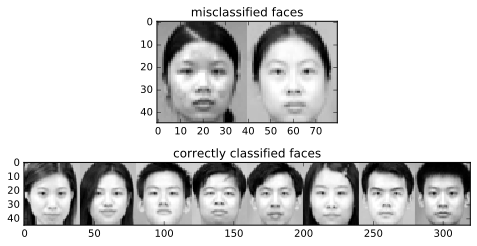

In [11]:
# predYtest are the class predictions on the test set.

# find misclassified test images
inds = where(predYtest != testY) # get indices of misclassified test images
# make a montage
badimgs = image_montage(testX[inds], imsize=imgsize)

# find correctly classified test images
inds = where(predYtest == testY)
goodimgs = image_montage(testX[inds], imsize=imgsize)
    
plt.figure(figsize=(8,4))
plt.subplot(2,1,1)
plt.imshow(badimgs, cmap='gray', interpolation='nearest')
plt.title('misclassified faces')
plt.subplot(2,1,2)
plt.imshow(goodimgs, cmap='gray', interpolation='nearest')
plt.title('correctly classified faces')
plt.show()

_Why did the classifier make incorrect predictions on the misclassified faces?_

- The two misclassified faces are infact a rare case were the female has short hair or has covered her long hair from the camera short. the classifier checks for long hair to determine the geneder. In this case the long hair is absent and hence the misclassification.

# 3. Support Vector Machine
Now train a support vector machine (SVM) on the same training and testing data.  Use cross-validation to select the best $C$ parameter.

In [16]:
### INSERT YOUR CODE HERE
paramgrid = {'C': logspace(-3,3,13)}
print paramgrid

# setup the cross-validation object
# pass the SVM object, parameter grid, and number of CV folds
svmcv = grid_search.GridSearchCV(svm.SVC(kernel='linear'), paramgrid, cv=5)

# run cross-validation (train for each split)
svmcv.fit(trainX, trainY);
# view results for each parameter
svmcv.grid_scores_



{'C': array([  1.00000000e-03,   3.16227766e-03,   1.00000000e-02,
         3.16227766e-02,   1.00000000e-01,   3.16227766e-01,
         1.00000000e+00,   3.16227766e+00,   1.00000000e+01,
         3.16227766e+01,   1.00000000e+02,   3.16227766e+02,
         1.00000000e+03])}


[mean: 0.62500, std: 0.00000, params: {'C': 0.001},
 mean: 0.87500, std: 0.07906, params: {'C': 0.0031622776601683794},
 mean: 0.90000, std: 0.09354, params: {'C': 0.01},
 mean: 0.90000, std: 0.09354, params: {'C': 0.031622776601683791},
 mean: 0.90000, std: 0.09354, params: {'C': 0.10000000000000001},
 mean: 0.90000, std: 0.09354, params: {'C': 0.31622776601683794},
 mean: 0.90000, std: 0.09354, params: {'C': 1.0},
 mean: 0.90000, std: 0.09354, params: {'C': 3.1622776601683791},
 mean: 0.90000, std: 0.09354, params: {'C': 10.0},
 mean: 0.90000, std: 0.09354, params: {'C': 31.622776601683793},
 mean: 0.90000, std: 0.09354, params: {'C': 100.0},
 mean: 0.90000, std: 0.09354, params: {'C': 316.2277660168379},
 mean: 0.90000, std: 0.09354, params: {'C': 1000.0}]

Calculate the training and test accuracy for the SVM classifier.

test accuracy = 0.8


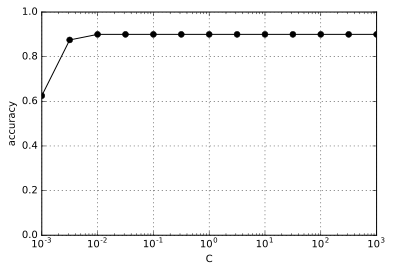

In [20]:
### INSERT YOUR CODE HERE

allC = []
allscores = []
for cvrun in svmcv.grid_scores_:
    allC.append(cvrun.parameters['C'])
    allscores.append(cvrun.mean_validation_score)

plt.figure()
plt.semilogx(allC, allscores, 'ko-')
plt.ylim((0,1))
plt.xlabel('C');
plt.ylabel('accuracy')
plt.grid(True)

predYtest = svmcv.predict(testX)
acc = metrics.accuracy_score(testY,predYtest)
print "test accuracy = " + str(acc)

Similar to before, plot an image of the hyperplane parameters $w$, and view the misclassified and correctly classified test images.

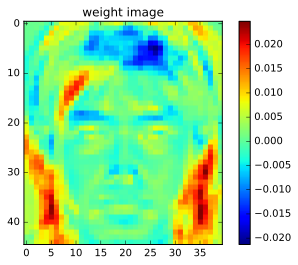

In [18]:
### INSERT YOUR CODE HERE

bestSVC = svmcv.best_estimator_
wimg = bestSVC.coef_.reshape(imgsize)      # get the w and reshape into an image
plt.imshow(wimg, interpolation='nearest')
plt.colorbar()
plt.title("weight image")
plt.show()



*** As stated before in Logistic regression part, even the svm considers the feature of having long hair to determine the gender

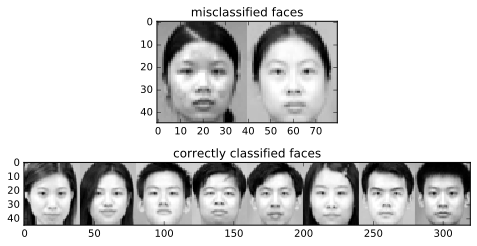

In [19]:
### INSERT YOUR CODE HERE


# find misclassified test images
inds = where(predYtest != testY) # get indices of misclassified test images
# make a montage
badimgs = image_montage(testX[inds], imsize=imgsize)

# find correctly classified test images
inds = where(predYtest == testY)
goodimgs = image_montage(testX[inds], imsize=imgsize)
    
plt.figure(figsize=(8,4))
plt.subplot(2,1,1)
plt.imshow(badimgs, cmap='gray', interpolation='nearest')
plt.title('misclassified faces')
plt.subplot(2,1,2)
plt.imshow(goodimgs, cmap='gray', interpolation='nearest')
plt.title('correctly classified faces')
plt.show()



_Are there any differences between the $w$ for logistic regressiona and the $w$ for SVM?  Is there any interpretation for the differences?_

- **The SVM Classifer looks for two things:**
    - *Negative Weightage for blue space, i.e hair on the top of the head, since everyone has hair there*
    - *Positive Weightage for red space, i.e hair below head, mostly women have hair there*
- **Both the classifiers have almost similar w and hence both look at the same feature i.e long hair to determine the gender 
- **Again a similar problem has happened, the classifier has given too much weightage to hair below the head and hence the image is misclassified**
- **Example case: A similar problem can happen if there is a male with long hair**